In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [20]:
# parse logging data
per_layer_loss = {i: [] for i in range(32)}
with open("/root/lm-evaluation-harness/results/mixtral-8x7b-reroute-threshold-0.9-Opt-K2-GToken-WikiText-Debug/log.txt") as f:
    for line in f:
        if "mean loss per token" in line:
            layer_id = int(line.split("layer")[1].split()[0].strip())
            try:
                mean_loss_per_token = line.split("mean loss per token:")[1].strip()
                if mean_loss_per_token == "None":
                    continue
                mean_loss_per_token = float(mean_loss_per_token)
                if mean_loss_per_token < 1e-5:
                    continue
            except:
                print(line)
                break
            per_layer_loss[layer_id].append(mean_loss_per_token)


per_layer_avg_loss = {}
for layer_id, losses in per_layer_loss.items():
    per_layer_avg_loss[layer_id] = sum(losses) / len(losses)

In [21]:
# plot per layer loss distribution
layer_ids = []
losses = []
for layer_id, loss in per_layer_loss.items():
    for l in loss:
        layer_ids.append(layer_id)
        losses.append(l)

df = pd.DataFrame({"layer_id": layer_ids, "loss": losses})

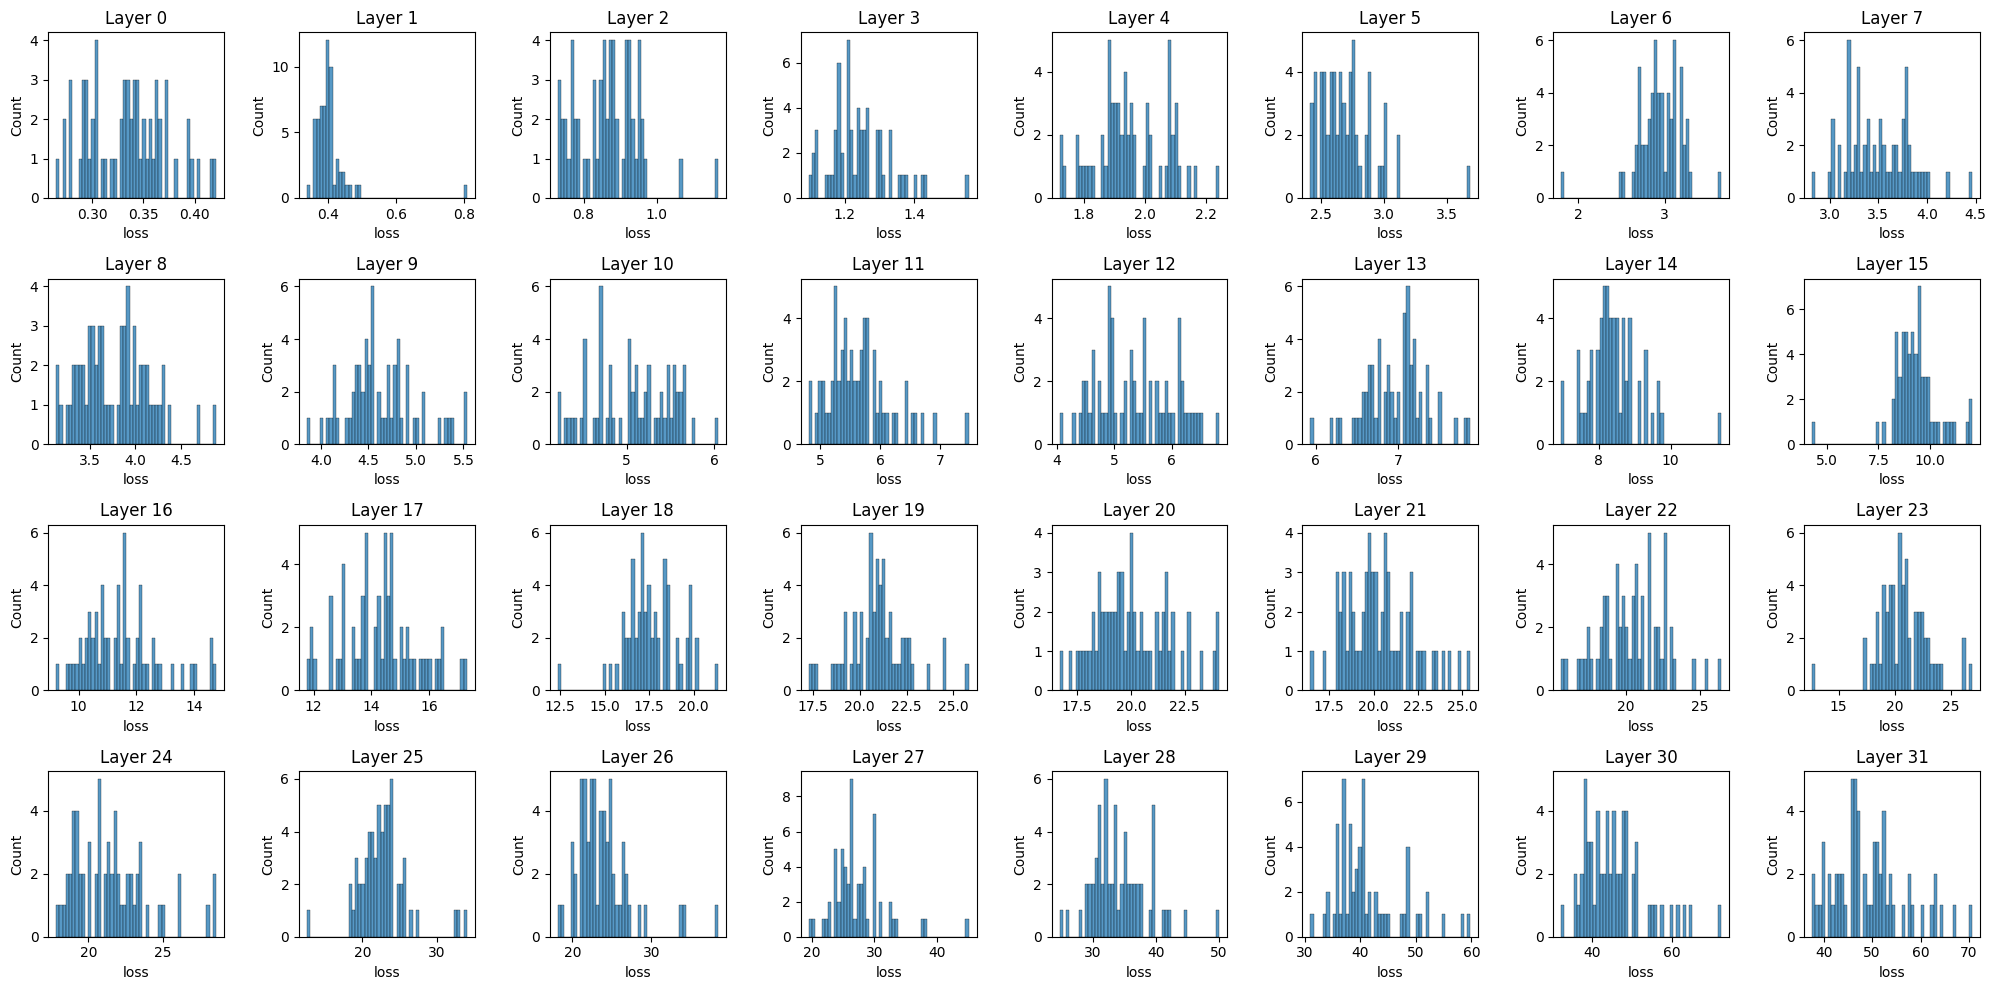

In [23]:
fig, axes = plt.subplots(4, 8, figsize=(20,10))
for i in range(32):
    ax = axes[i//8, i%8]
    sns.histplot(df[df["layer_id"] == i]["loss"], ax=ax, bins=50)
    ax.set_title(f"Layer {i}")
plt.tight_layout()

In [ ]:
fig.savefig("per_layer_loss_distribution.pdf", bbox_inches='tight')

{0: 0.32831728683525835,
 1: 0.3991872295958027,
 2: 0.8520468483185047,
 3: 1.2226145409752651,
 4: 1.9199942423166334,
 5: 2.6646020011991984,
 6: 2.9022519158860396,
 7: 3.450035960088571,
 8: 3.71821581971947,
 9: 4.554134804517253,
 10: 4.982835490474761,
 11: 5.56483096068117,
 12: 5.371530673664198,
 13: 6.965169811470965,
 14: 8.423008584673251,
 15: 9.277559208133743,
 16: 11.503471115553074,
 17: 14.309422424765,
 18: 17.628202507118218,
 19: 20.930947619221072,
 20: 20.074173383735083,
 21: 20.382556232163008,
 22: 20.406157680677158,
 23: 20.823414433811376,
 24: 21.502414519136597,
 25: 22.73015637194044,
 26: 23.897213601319617,
 27: 27.398302004091555,
 28: 34.244380263416765,
 29: 41.42968298618716,
 30: 45.821789475699944,
 31: 49.44493983516086}

In [8]:
eval_df = pd.read_csv("/root/vllm/benchmarks/weight_explorer/importance/neuron_importance_eval.csv")

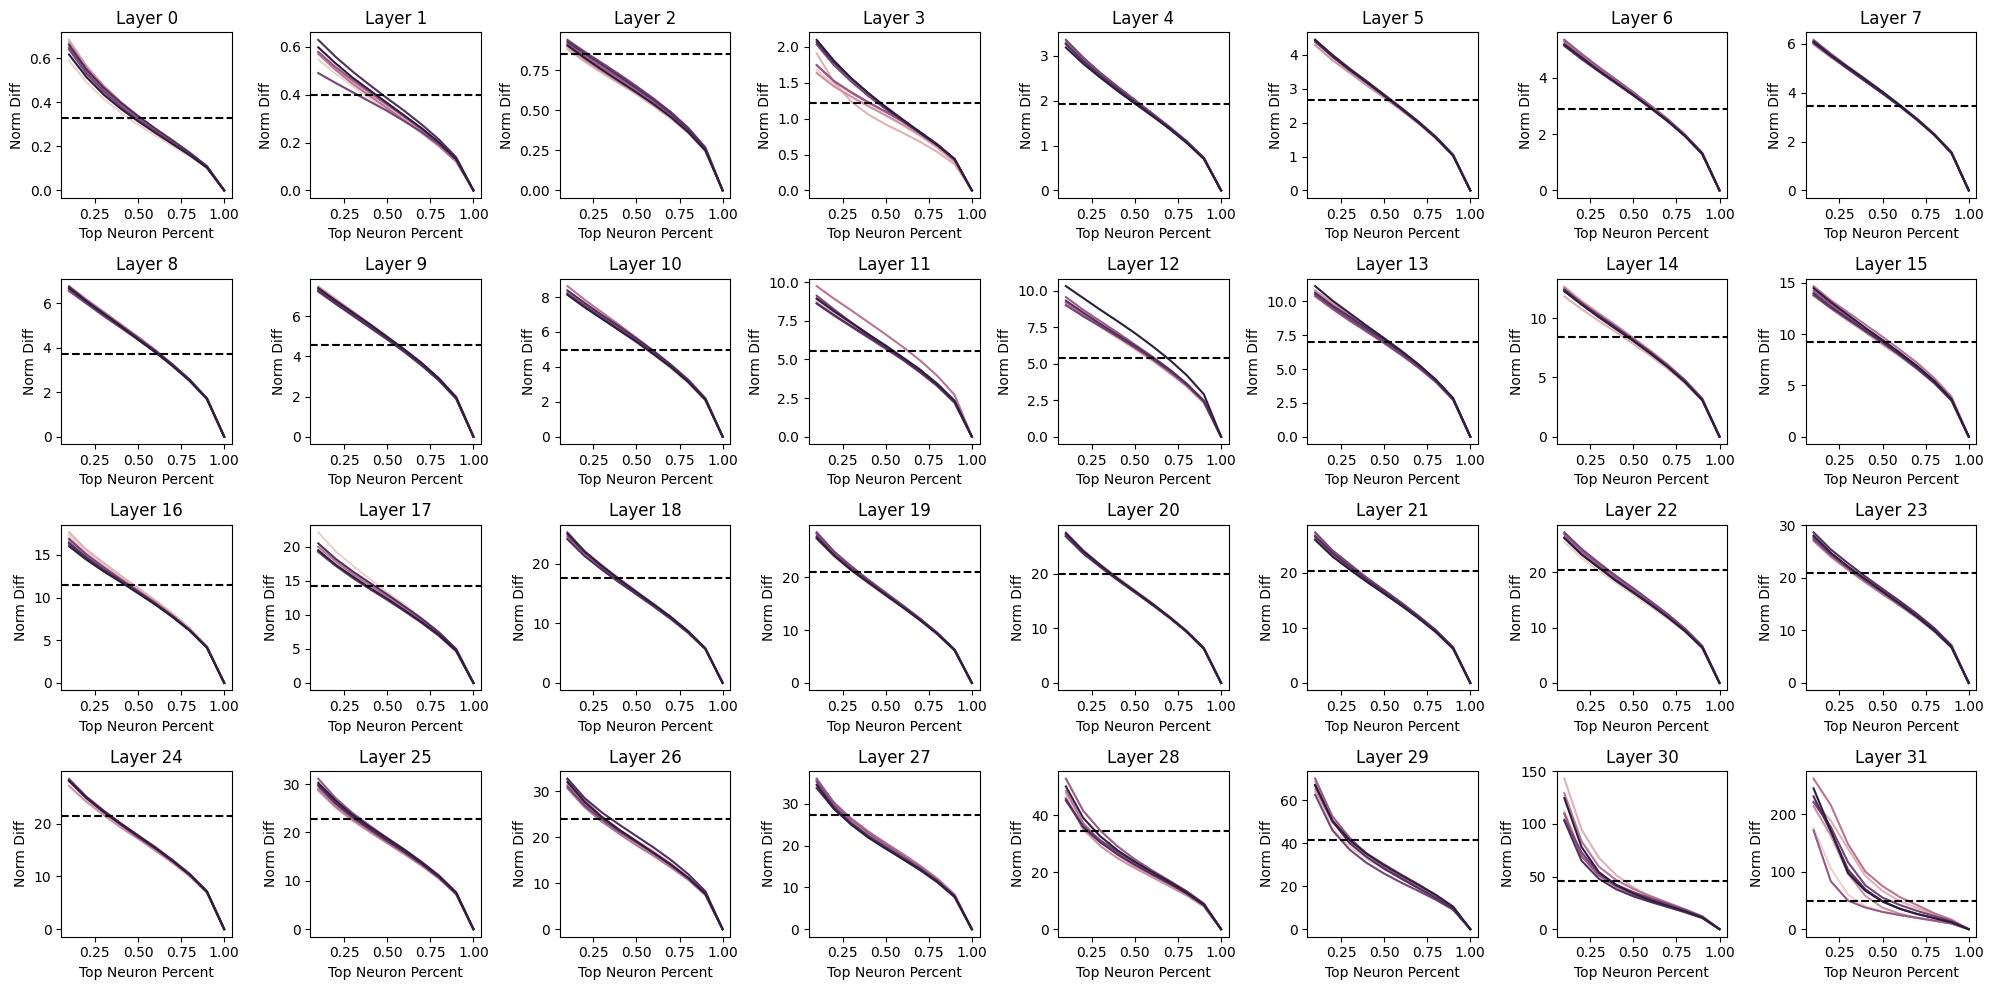

In [15]:
# plot
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    ax = axes[i // 8, i % 8]
    sns.lineplot(x="top_neuron_percent", y="norm_diff", data=eval_df[eval_df["layer_id"] == i], hue="expert_id", ax=ax)
    ax.legend().remove()
    # draw a line for the average loss
    ax.axhline(per_layer_avg_loss[i], color="black", linestyle="--")
    ax.set_title(f"Layer {i}")
    ax.set_xlabel("Top Neuron Percent")
    ax.set_ylabel("Norm Diff")
plt.tight_layout()

In [16]:
fig.savefig("neuron_importance_eval.pdf", bbox_inches="tight")